In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torchvision.utils import  save_image, make_grid
from torch.optim import Adam

In [ ]:
dataset_path = '~/dataset'
cuda = True
DEVICE = torch.device("cuda:0" if cuda else "cpu")
dataset = 'MNIST'
image_size = (32,32,3) if dataset == 'CIFAR10' else (28,28,1)

n_timesteps = 1000
time_embeding_dim = 256
n_layers = 8
hidden_dims = 256
beta_min_max = [1e-4,2e-2]

train_batch_size = 128
inference_batch_size = 64

lr = 5e-5
epoch = 100

hidden_dims = [hidden_dims for _ in range(n_layers)]

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as  transforms
from torch.utils.data import DataLoader


transformis = transforms.Compose([
    transforms.ToTensor()
])

kwargs = {'num_workers':1,'pin_memory':True}

if dataset == 'MNIST':
  dataset_train = MNIST(dataset_path,transform =transformis, train = True, download = True )
  dataset_inference = MNIST(dataset_path,transform =transformis, train = False, download = True )
else:
  dataset_train = CIFAR10(dataset_path,transform =transformis, train = True, download = True )
  dataset_inference = CIFAR10(dataset_path,transform =transformis, train = False, download = True )

data_train = DataLoader(dataset = dataset_train,batch_size=train_batch_size ,shuffle = True,  **kwargs)
data_test = DataLoader(dataset = dataset_train,batch_size=inference_batch_size ,shuffle = True,  **kwargs)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16081070.90it/s]


Extracting /root/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /root/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 519131.47it/s]


Extracting /root/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /root/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4375656.51it/s]


Extracting /root/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6427303.90it/s]

Extracting /root/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/dataset/MNIST/raw



In [ ]:

import math

In [ ]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self,dim):
      super().__init__()
      self.dim = dim
    def forward(self,x):
      device = x.device
      half_dim = self.dim//2
      emb = math.log(10000) / (half_dim -1)
      emb = torch.exp(torch.arange(half_dim,device = device) * -emb)
      emb = x[:,None] * emb[None,:]
      emb = torch.cat([emb.sin(),emb.cos()], dim = 1 )
      return emb


In [ ]:
class ConvBlock(nn.Conv2d):
  def __init__(self,c_i, c_o, k_s,function_fn = None, drop_r = 0., padding = 'same', stride = 1, groups= 1,dilation = 1, gn_groups = 8, gn = False, bias = True):
    if padding == 'same':
      padding = k_s // 2 * dilation

    super(ConvBlock,self).__init__(c_i, c_o, k_s, padding = padding, stride = stride, groups= groups,dilation = dilation, bias = bias)
    self.activation = nn.SiLU() if function_fn else None
    self.group_norm = nn.GroupNorm(gn_groups,c_o) if gn else None
  def forward(self,x,time_embeding= None, residual= False):
    if residual:
      x = x + time_embeding
      y = x
      x = super(ConvBlock, self).forward(x)
      y = y + x
    else:
      y = super(ConvBlock,self).forward(x)

    y = self.group_norm(y) if self.group_norm is not None else y
    y = self.activation(y) if self.activation is not None else y

    return y

In [ ]:
class Denoiser(nn.Module):
  def __init__(self, image_resolution, hidden_dim = [256,256], diffusion_t_m_d =256 , n_times = 10000):
    super(Denoiser, self).__init__()

    _,_,image_C = image_resolution
    self.time_emb = SinusoidalPosEmb(diffusion_t_m_d)
    self.in_project = ConvBlock(image_C,hidden_dim[0], k_s = 7)
    self.time_project = nn.Sequential(
        ConvBlock(diffusion_t_m_d,hidden_dim[0],k_s=1,function_fn=True),
        ConvBlock(hidden_dim[0],hidden_dim[0],k_s=1))
    self.convolutions = nn.ModuleList([ConvBlock(hidden_dim[0],hidden_dim[0],k_s = 3)])

    for i in range(1,len(hidden_dim)):
      self.convolutions.append(ConvBlock(hidden_dim[i-1],hidden_dim[i], k_s =3 ,dilation= 3**((i-1)//2),function_fn=True,gn_groups=8,gn=True))

    self.out_project = ConvBlock(hidden_dim[-1], image_C, k_s= 3)
  def forward(self,x_p,t):
    y = x_p

    time = self.time_emb(t)
    time = self.time_project(time.unsqueeze(-1).unsqueeze(-2))

    y = self.in_project(y)

    for i in range(len(self.convolutions)):
      y  = self.convolutions[i](y,time,residual= True)

    y = self.out_project(y)
    return y

In [ ]:
model = Denoiser(image_size, hidden_dims, time_embeding_dim,n_timesteps).to(DEVICE)

In [ ]:
class Denoise(nn.Module):
  def __init__(self, model,image_resolution,n_times,beta_minmax, device = 'cuda' ):
    super(Denoise, self).__init__()
    self.device = device
    self.n_times = n_times
    self.image_H,self.image_W,self.image_C = image_resolution

    self.model = model

    beta0,betaM = beta_minmax[0],beta_minmax[-1]
    betas = torch.linspace(beta0,betaM,n_times).to(device)
    self.betas_s = torch.sqrt(betas)
    self.alphas = 1-betas
    self.alphas_s = torch.sqrt(self.alphas)
    alphas_c = torch.cumprod(self.alphas, dim= 0)
    self.alphas_c_s_1 = torch.sqrt(1-alphas_c)
    self.alphas_c_s = torch.sqrt(alphas_c)

  def extract(self,a,t,x_shape):
    b, *_ = t.shape
    out = a.gather(-1,t)
    return out.reshape(b,*((1,)* (len(x.shape)-1)))
  def scale_to_one(self,x):
    return (x*2)-1
  def rescale(self,x):
    return (x+1)*0.5
  def make_noisy(self,x_zeros,t):
    noise = torch.randn_like(x_zeros).to(self.device)
    sqrt_alpha_bar =  self.extract(self.alphas_c_s,t,x_zeros)
    sqrt_alpha_1 =  self.extract(self.alphas_c_s_1,t,x_zeros)
    noisy_sample = x_zeros * sqrt_alpha_bar + noise * sqrt_alpha_1
    return noisy_sample.detach(), noise

  def forward(self,x):

    x_zeros = self.scale_to_one(x)

    B,_,_,_ = x_zeros.shape

    t = torch.randint(low=0, high=self.n_times, size= (B,)).long().to(self.device)

    pertub_image, noise = self.make_noisy(x_zeros,t)
    pred_noise = self.model(pertub_image,t)

    return pertub_image,noise, pred_noise

  def denoise_at_t(self,x_t,timestep,t):

    B,_,_,_ = x_t.shape

    if t > 0:
      z = torch.randn_like(x_t).to(self.device)
    else:
      z = torch.zeros_like(x_t).to(self.device)

    noise_pred = model(x_t,timestep)
    alpha = self.extract(self.alphas, timestep, x_t.shape)
    sqrt_alpha = self.extract(self.alphas_s, timestep, x_t.shape)
    sqrt_one_minus_alpha_bar = self.extract(self.alphas_c_s_1, timestep, x_t.shape)
    sqrt_beta = self.extract(self.betas_s, timestep, x_t.shape)

    x_t_minus_1 = 1/sqrt_alpha *  (x_t - (1-alpha)/sqrt_one_minus_alpha_bar*noise_pred) + sqrt_beta*z

    return x_t_minus_1.clap(-1,1)

  def sample(self,N):
    x_t = torch.randn((N,self.image_C,self.image_H,self.image_W)).to(self.device)

    for t in range(self.n_times,0,-1):
      timestep = torch.tensor([t]).repeat_interleave(N,dim=0).long().to(self.device)
      x_t = self.denoise_at_t(x_t,timestep,t)
    x_0 = self.rescale(x_t)
    return x_0

In [ ]:
Diffusion = Denoise(model,image_size,n_timesteps,beta_min_max,DEVICE).to(DEVICE)

In [ ]:
optmizer = Adam(Diffusion.parameters(),lr=5e-4)
rating_loss= nn.MSELoss()

In [ ]:
model.eval()
for idx ,(x,_)in enumerate(data_test):
  x = x.to(DEVICE)
  images,n_p,noise = Diffusion(x)
  images = Diffusion.rescale(images)
  break

In [ ]:
def show_image(image,idx):
  fig = plt.figure()
  plt.imshow(image[idx].transpose(0, 1).transpose(1, 2).detach().cpu().numpy())

In [ ]:
images.shape

torch.Size([64, 1, 28, 28])

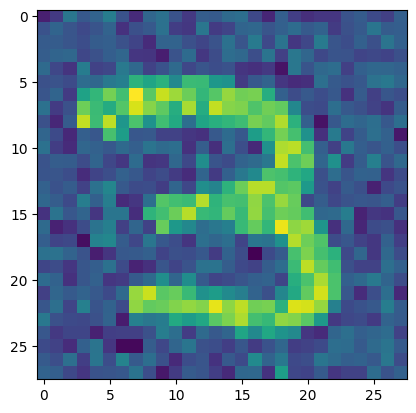

In [ ]:
show_image(images,12)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Number of model parameters: ", count_parameters(Diffusion))

Number of model parameters:  4870913


In [ ]:
model.train()
for epoch in range(20):
  noise_loss_prec = 0
  for idx,(x,_) in tqdm(enumerate(data_train), total=len(data_train)):
    optmizer.zero_grad()
    x = x.to(DEVICE)
    perturbed_i,predict,noise = Diffusion(x)

    loss = rating_loss(predict,noise)

    noise_loss_prec += loss.item()

    optmizer.step()
    loss.backward()

  print("\tEpoch", epoch + 1, "complete!", "\tDenoising Loss: ", noise_loss_prec / idx)

print("Finish!!")

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 469/469 [05:21<00:00,  1.46it/s]

	Epoch 1 complete! 	Denoising Loss:  1.2528775724080892



100%|██████████| 469/469 [05:26<00:00,  1.44it/s]

	Epoch 2 complete! 	Denoising Loss:  1.2527163474478273



100%|██████████| 469/469 [05:26<00:00,  1.44it/s]

	Epoch 3 complete! 	Denoising Loss:  1.253864298009465



100%|██████████| 469/469 [05:26<00:00,  1.44it/s]

	Epoch 4 complete! 	Denoising Loss:  1.2534519775300963



100%|██████████| 469/469 [05:26<00:00,  1.44it/s]

	Epoch 5 complete! 	Denoising Loss:  1.2529013039719346



100%|██████████| 469/469 [05:26<00:00,  1.44it/s]

	Epoch 6 complete! 	Denoising Loss:  1.2525463733408186



100%|██████████| 469/469 [05:26<00:00,  1.44it/s]

	Epoch 7 complete! 	Denoising Loss:  1.2533777238976243



100%|██████████| 469/469 [05:26<00:00,  1.44it/s]

	Epoch 8 complete! 	Denoising Loss:  1.2529259782571058



100%|██████████| 469/469 [05:26<00:00,  1.44it/s]

	Epoch 9 complete! 	Denoising Loss:  1.2529057427349253



 64%|██████▍   | 299/469 [03:28<01:58,  1.43it/s]

In [ ]:
model.eval()

with torch.no_grad():
    generated_images = Diffusion.sample(64)